<a href="https://colab.research.google.com/github/soerenml/tensorflow-certificate/blob/master/Time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series data

Characteristics of time series:

*   Trend
*   Seasonality
*   Autocorrelation
*   Noise

Those characteristics can be stationary or non-stationary. Stationarity characterizes time series which do not change overtime. Such time series have no trends or seasonality. Hence, they are identically distrubuted - but not independent. A time series which is non-stationary would include the dot.com bubble.

Trends can have a significant impact on the mean. I.e. compare the average down jones between 1984 and 2020. Seasonality on the other side can have a significant impact on the variance. I.e. the great sell-off in December creates sign. changes in variance.




# Create synthetic data

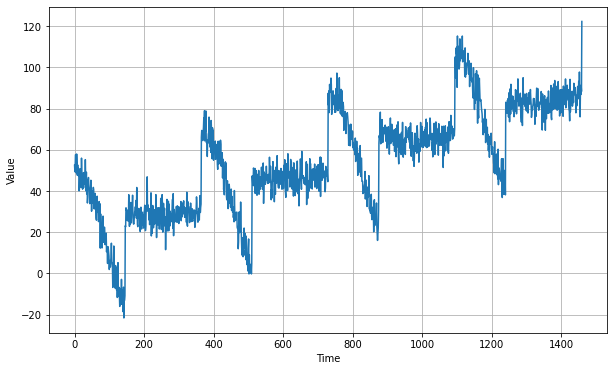

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

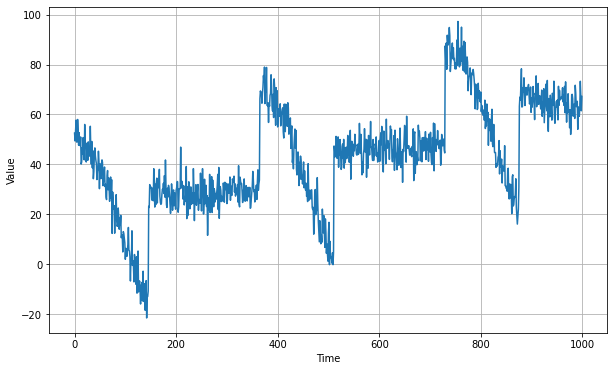

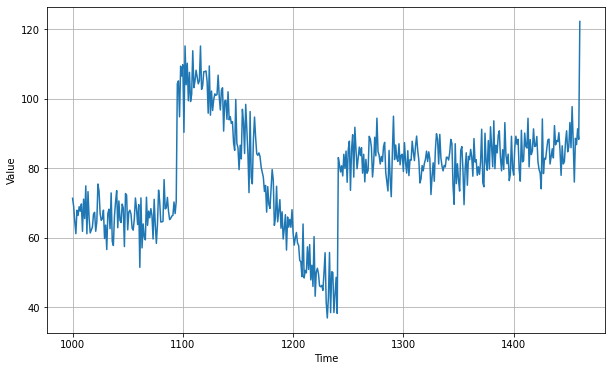

In [2]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Helper functions

In [3]:
# Function to measure MAE and MSE
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.metrics import mean_absolute_error

def mse_mae(x_valid, pred):
  """
  The function takes validation and prediction data
  to calculate MAE and MSE.
  """
  print("MSE: {}".format(round(mean_squared_error(x_valid, pred).numpy())))
  print("MAE: {}".format(round(mean_absolute_error(x_valid, pred).numpy())))

In [4]:
def model_analysis():
  '''
  The function calls preditions from the underlying model,
  plots them, and calls a function calculating MAE and MSE.
  '''
  # Get forecasts
  forecast = []
  for time in range(len(series) - _WINDOW_SIZE):
    forecast.append(model.predict(series[time:time + _WINDOW_SIZE][np.newaxis]))

  forecast = forecast[split_time-_WINDOW_SIZE:]
  results = np.array(forecast)[:, 0, 0]

  # Plot forecasts
  plt.figure(figsize=(10, 6))
  plot_series(time_valid, x_valid)
  plot_series(time_valid, results)

  # Print goodness metrics
  mse_mae(x_valid, results)

In [5]:
def opt_lr():
  """
  The plot lr and loss and selects the best learning rate.
  """
  lrs = 1e-8 * (10 ** (np.arange(_EPOCHS) / 20))
  df = pd.DataFrame({'lrs':lrs, 'loss': history.history["loss"]})
  min_loss = df['loss'].min()
  best_learning_rate = df['lrs'][df['loss']==df['loss'].min()]
  return best_learning_rate

def print_learning_rates():
  lrs = 1e-8 * (10 ** (np.arange(_EPOCHS) / 20))
  df = pd.DataFrame({'lrs':lrs, 'loss': history.history["loss"]})
  min_loss = df['loss'].min()
  best_learning_rate = df['lrs'][df['loss']==df['loss'].min()]
  plt.semilogx(lrs, history.history["loss"])
  plt.axis([1e-8, 1e-3, 0, 300])
  print("Optimal learning rate: {}".format(best_learning_rate))

# Statistical modelling

## Naive forecast

Predict t with t-1.

In [6]:
naive_forecast = series[split_time - 1:-1]

MSE: 62.0
MAE: 6.0


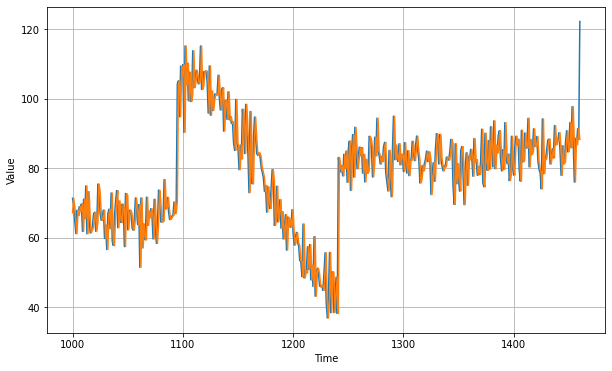

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

mse_mae(x_valid, naive_forecast)

## Moving average

Calculate a moving window to predict t+1.

The problem: trend and seasonality heavily affect our forecast.

MSE: 107.0
MAE: 7.0


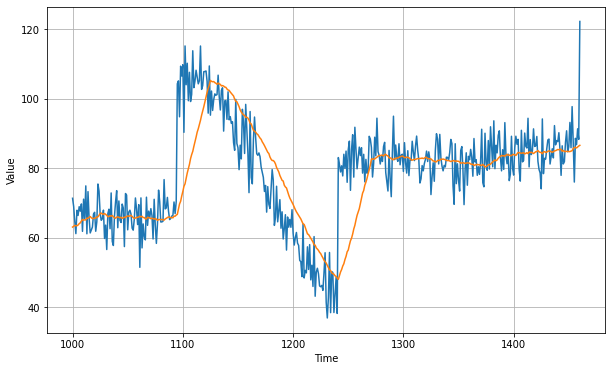

In [8]:
def moving_average_forecast(series, _WINDOW_SIZE):
  forecast = []
  for time in range(len(series) - _WINDOW_SIZE):
    forecast.append(series[time:time + _WINDOW_SIZE].mean())
  return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

mse_mae(x_valid, moving_avg)

## Differenciating

We will use differenciating to get rid of trend and seasonality. To do so we calculate t - t(-365).

# ML modelling

## Data ingestion

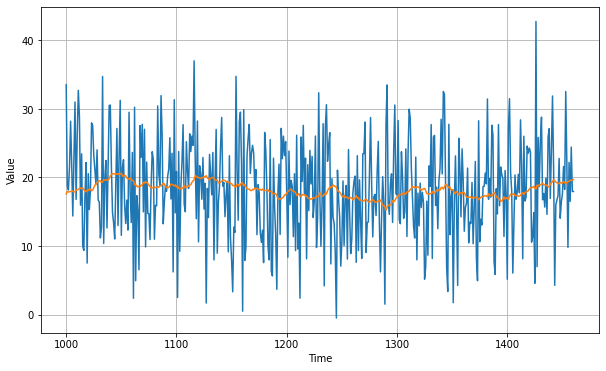

In [9]:
# Take difference from today - one year ago.
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

# Add a moving average of 50 days.
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

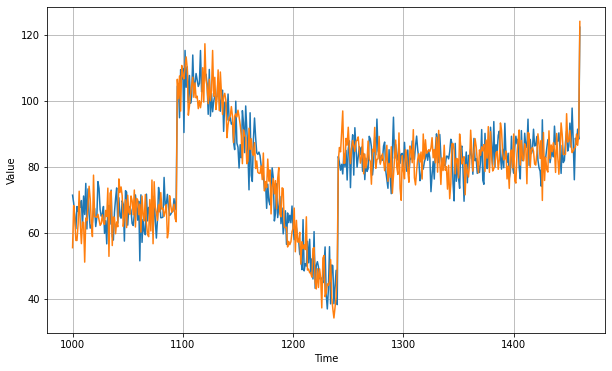

In [10]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [11]:
mse_mae(x_valid, diff_moving_avg_plus_past)

MSE: 53.0
MAE: 6.0


### Prepare data with tf.data [example]

In [12]:
"""This piece of code shows how to ingest time series data using td.data"""

# Create ten datapoints.
dataset = tf.data.Dataset.range(10)
# Create a window of 5 with shift 1 not allowing windows with < 5 items.
dataset = dataset.window(5, shift=1, drop_remainder=True)
# Use flat_map if you want to make sure that the order of your dataset stays the same.
dataset = dataset.flat_map(lambda window: window.batch(5))
# Split features and labels.
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# Suffle the data.
dataset = dataset.shuffle(buffer_size=10)
# Define batches and prefetch the data.
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[3 4 5 6]
 [0 1 2 3]]
y =  [[7]
 [4]]
x =  [[1 2 3 4]
 [5 6 7 8]]
y =  [[5]
 [9]]
x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]


### Ingest data

In [13]:
# todo - why are we using window size + 1?
_WINDOW_SIZE = 20
batch_size = 32
shuffle_buffer_size = 1000

# Ingest data with tf.Data
def windowed_dataset(series, __WINDOW_SIZE, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(__WINDOW_SIZE + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(__WINDOW_SIZE + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Linear regression

We are creating a single layer NN. Technically, a simple linear regression.

In [14]:
dataset = windowed_dataset(x_train, _WINDOW_SIZE, batch_size, shuffle_buffer_size)
print(dataset)

""" We are using a different model definition here as we would like to have
easier access to the underlying layers"""
l0 = tf.keras.layers.Dense(1, input_shape=[_WINDOW_SIZE])
model = tf.keras.models.Sequential([l0])
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

# Print weights
print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[ 0.0053462 ],
       [ 0.00768004],
       [-0.08132128],
       [ 0.02786803],
       [ 0.04737977],
       [ 0.08445108],
       [-0.09230985],
       [-0.05782074],
       [ 0.08469801],
       [-0.01321361],
       [ 0.02932899],
       [-0.04003275],
       [-0.08414439],
       [ 0.10267714],
       [ 0.04724028],
       [ 0.07071802],
       [-0.02346985],
       [ 0.16187161],
       [ 0.2558705 ],
       [ 0.47885883]], dtype=float32), array([0.01429534], dtype=float32)]


MSE: 47.0
MAE: 5.0


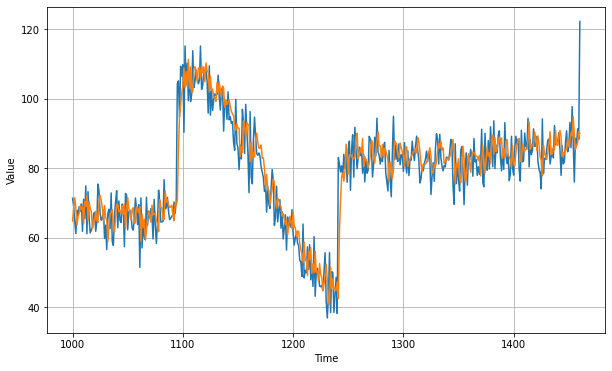

In [15]:
forecast = []

for time in range(len(series) - _WINDOW_SIZE):
  forecast.append(model.predict(series[time:time + _WINDOW_SIZE][np.newaxis]))

forecast = forecast[split_time-_WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

mse_mae(x_valid, results)

## DNN

### Find optimal learning rate

In [16]:
_EPOCHS = 100
_WINDOW_SIZE = 20

# We are using the function API
inputs = tf.keras.Input(shape=[_WINDOW_SIZE])
l1 = tf.keras.layers.Dense(10, activation="relu")(inputs)
l2 = tf.keras.layers.Dense(10, activation="relu")(l1)
outputs = tf.keras.layers.Dense(1)(l2)

model = keras.Model(inputs=inputs, outputs=outputs, name="dnn_time_series")
model.summary()

# Callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=_EPOCHS, callbacks=[lr_schedule], verbose=0)

Model: "dnn_time_series"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


Optimal learning rate: 67    0.000022
Name: lrs, dtype: float64


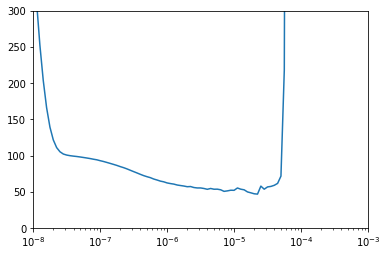

In [17]:
print_learning_rates()

### Re-run with optimal learing rate

In [18]:
# Retrain model with new learning rate.
# We can't reuse the model intead, we need to redefine it.

# We are using the function API
inputs = tf.keras.Input(shape=[_WINDOW_SIZE])
l1 = tf.keras.layers.Dense(10, activation="relu")(inputs)
l2 = tf.keras.layers.Dense(10, activation="relu")(l1)
outputs = tf.keras.layers.Dense(1)(l2)

model = keras.Model(inputs=inputs, outputs=outputs, name="dnn_time_series")
model.summary()

# Callback
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=opt_lr().iloc[0], momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=0)

Model: "dnn_time_series"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


MSE: 45.0
MAE: 5.0


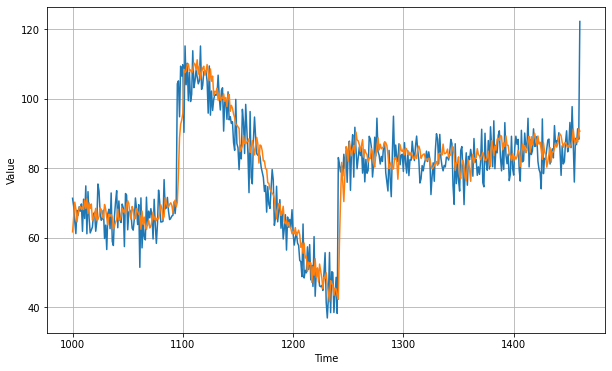

In [19]:
model_analysis()

## RNN

### Find optimal learning rate

In [20]:
# Clear RAM
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, _WINDOW_SIZE, batch_size=128, shuffle_buffer=shuffle_buffer_size)
  
model = tf.keras.models.Sequential([
  # We are using lambda layers to allow preprocessig within the model.                                  
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  # Multiplying the output of the final layer by 100
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Define callbacl function to find optimal learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 38ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 38ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 193.5110 - mae: 194.0110
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 187.8583 - mae: 188.3583
Epoch 7/100
8/8 [==============================] - 0s 38ms/step - loss: 185.3787 - mae: 185.8787
Epoch 8/100
8/8 [==============================] - 0s 36ms/step - loss: 182.5484 - mae: 183.0484
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 179.3127 - mae: 179.8127
Epoch 10/100
8/8 [==============================] - 0s 38ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

Optimal learning rate: 66    0.00002
Name: lrs, dtype: float64


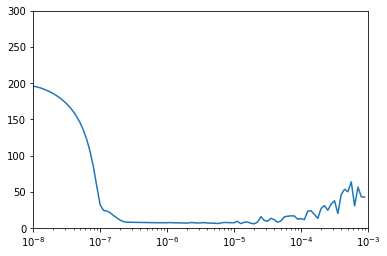

In [21]:
print_learning_rates()

### Re-run with optimal learning rate

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, _WINDOW_SIZE, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=opt_lr().iloc[0], momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 35ms/step - loss: 89.8010 - mae: 90.2997
Epoch 2/400
8/8 [==============================] - 0s 34ms/step - loss: 33.6124 - mae: 34.1110
Epoch 3/400
8/8 [==============================] - 0s 33ms/step - loss: 18.0724 - mae: 18.5671
Epoch 4/400
8/8 [==============================] - 0s 36ms/step - loss: 13.8244 - mae: 14.3166
Epoch 5/400
8/8 [==============================] - 0s 34ms/step - loss: 10.3704 - mae: 10.8613
Epoch 6/400
8/8 [==============================] - 0s 34ms/step - loss: 8.8637 - mae: 9.3506
Epoch 7/400
8/8 [==============================] - 0s 33ms/step - loss: 6.7229 - mae: 7.2056
Epoch 8/400
8/8 [==============================] - 0s 35ms/step - loss: 6.4123 - mae: 6.8901
Epoch 9/400
8/8 [==============================] - 0s 36ms/step - loss: 6.1673 - mae: 6.6487
Epoch 10/400
8/8 [==============================] - 0s 34ms/step - loss: 5.4206 - mae: 5.9003
Epoch 11/400
8/8 [==============================] - 0s 31ms

MSE: 60.0
MAE: 6.0


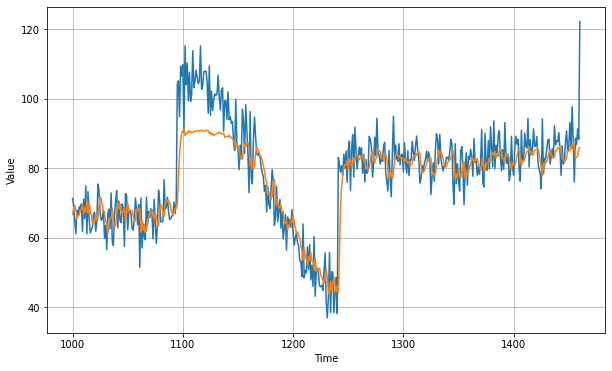

In [23]:
model_analysis()

## LSTM

### Find optimal learning rate

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, _WINDOW_SIZE, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  # We are adding two LSTM bidirectional layers                    
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 21.6170 - mae: 22.1120
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 21.5606 - mae: 22.0553
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 21.4693 - mae: 21.9635
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 21.3590 - mae: 21.8526
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 21.2319 - mae: 21.7241
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 21.0881 - mae: 21.5810
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 20.9298 - mae: 21.4234
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 20.7610 - mae: 21.2542
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 20.5696 - mae: 21.0635
Epoch 10/100
8/8 [==============================] - 0s 20ms/step - loss: 20.3591 - mae: 20.8510
Epoch 11/100
8/8 [==============================]

Optimal learning rate: 74    0.00005
Name: lrs, dtype: float64


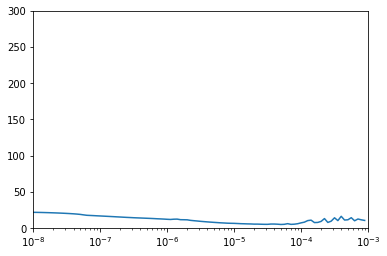

In [25]:
print_learning_rates()

### Re-run with optimal learning rate

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, _WINDOW_SIZE, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  # We are adding two LSTM bidirectional layers                    
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=opt_lr().iloc[0], momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 19ms/step - loss: 15.4303 - mae: 15.9266
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 9.5851 - mae: 10.0716
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 7.0630 - mae: 7.5468
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 6.0957 - mae: 6.5788
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 5.7558 - mae: 6.2396
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 5.4489 - mae: 5.9242
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 6.5567 - mae: 7.0415
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 6.5966 - mae: 7.0796
Epoch 9/100
8/8 [==============================] - 0s 21ms/step - loss: 7.4106 - mae: 7.9026
Epoch 10/100
8/8 [==============================] - 0s 20ms/step - loss: 6.3474 - mae: 6.8289
Epoch 11/100
8/8 [==============================] - 0s 21ms/step -

MSE: 77.0
MAE: 6.0


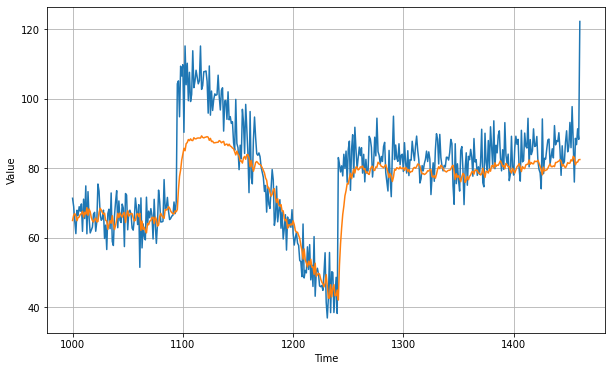

In [27]:
model_analysis()